<a href="https://colab.research.google.com/github/alessandro-rubin/databricks_training/blob/main/Databricks_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType, IntegerType, StringType, StructType, StructField, TimestampType
import random
import datetime
from pyspark.sql.functions import expr

# Create a Spark session
spark = SparkSession.builder.appName("ColabSparkSession").getOrCreate()

# Define the schema for the DataFrame
schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("VIN", StringType(), True),
    StructField("odometer", DoubleType(), True),
    StructField("rail_pressure", DoubleType(), True)
])

# Generate random data for each VIN
num_vins = 10
start_date = datetime.datetime(2023, 1, 1)
end_date = datetime.datetime(2023, 1, 8)
interval = datetime.timedelta(seconds=60)

data = []
for vin_index in range(num_vins):
    vin = f"VIN_{vin_index}"
    start_odometer = random.uniform(1000, 2000)
    end_odometer = random.uniform(start_odometer, start_odometer + 1000)
    avg_pressure = random.uniform(5, 7)
    
    current_date = start_date
    while current_date <= end_date:
        data.append((current_date, vin, start_odometer, random.gauss(avg_pressure, 2)))
        current_date += interval
        start_odometer += (end_odometer - start_odometer) / ((end_date - start_date).total_seconds() / 60)

# Create the DataFrame
df = spark.createDataFrame(data, schema)

# Show the DataFrame
df.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+-------------------+-----+------------------+-------------------+
|          timestamp|  VIN|          odometer|      rail_pressure|
+-------------------+-----+------------------+-------------------+
|2023-01-01 00:00:00|VIN_0|1053.7177158533827|  6.371554609633516|
|2023-01-01 00:01:00|VIN_0|1053.7728179792807|  8.417354610346653|
|2023-01-01 00:02:00|VIN_0|1053.8279146386978|  6.403629005934131|
|2023-01-01 00:03:00|VIN_0|1053.8830058321767| 10.648532773999138|
|2023-01-01 00:04:00|VIN_0|1053.9380915602592|  6.480701861094434|
|2023-01-01 00:05:00|VIN_0|1053.9931718234877|  5.495767457357792|
|2023-01-01 00:06:00|VIN_0|1054.0482466224046| 4.2784473571084405|
|2023-01-01 00:07:00|VIN_0|1054.1033159575516|  3.431942244980402|
|2023-01-01 00:08:00|VIN_0| 1054.158379829471|  5.318366343623311|
|2023-01-01 00:09:00|VIN_0|1054.2134382387046|  6.865400444423606|
|2023-01-01 00:10:00|VIN_0|105

In [4]:
# Calculate quantiles and median for rail pressure and odometer
quantiles_df = df.groupBy('VIN').agg(
    expr('percentile(rail_pressure, array(0.01, 0.99))').alias('rail_pressure_quantiles'),
    expr('percentile(odometer, 0.5)').alias('median_odometer')
)

# Join quantiles_df with the original DataFrame
df_with_quantiles = df.join(quantiles_df, 'VIN')

# Show the updated DataFrame
df_with_quantiles.show()

+-----+-------------------+------------------+------------------+-----------------------+------------------+
|  VIN|          timestamp|          odometer|     rail_pressure|rail_pressure_quantiles|   median_odometer|
+-----+-------------------+------------------+------------------+-----------------------+------------------+
|VIN_2|2023-01-01 00:00:00|1115.7993869820843|  4.54218735219839|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 00:01:00|1115.8664196701948|3.9063454337615617|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 00:02:00|1115.9334457082368| 7.722412951903761|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 00:03:00|1116.0004650968704| 4.431440060539123|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 00:04:00|1116.0674778367552| 7.458574894896534|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 00:05:00|1116.1344839285507|5.1826927732744394|   [1.98019787806940...|1381.6726521639187|
|VIN_2|2023-01-01 0

In [5]:
quantiles = df.groupBy("VIN").agg(expr("percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))"))
quantiles.show()

+-----+--------------------------------------------------------+
|  VIN|percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))|
+-----+--------------------------------------------------------+
|VIN_2|                                    [3.33509098948596...|
|VIN_3|                                    [1.86857243670407...|
|VIN_1|                                    [3.14798587267136...|
|VIN_0|                                    [2.24250486034721...|
|VIN_4|                                    [2.57540909382483...|
|VIN_5|                                    [2.03549004665659...|
|VIN_6|                                    [2.68189242344610...|
|VIN_9|                                    [2.31320052709509...|
|VIN_7|                                    [2.97775607384963...|
|VIN_8|                                    [2.80576103797672...|
+-----+--------------------------------------------------------+



In [6]:
quantiles.collect()

[Row(VIN='VIN_2', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[3.3350909894859653, 6.636635738375783, 10.01061200943705]),
 Row(VIN='VIN_3', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[1.868572436704076, 5.112337152510258, 8.428467828084528]),
 Row(VIN='VIN_1', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[3.1479858726713608, 6.385247827824382, 9.775365595753934]),
 Row(VIN='VIN_0', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.2425048603472124, 5.540455387938617, 8.879531047120116]),
 Row(VIN='VIN_4', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.575409093824837, 5.819049152360038, 9.0535779037164]),
 Row(VIN='VIN_5', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.035490046656595, 5.439510041057457, 8.778902920911705]),
 Row(VIN='VIN_6', percentile_approx(rail_pressure, array(0.05, 0.5, 0.95))=[2.6818924234461075, 5.911437631804125, 9.18676729012129]),
 Row(VIN='VIN_9', percentile_approx(rail_pressure, arr

In [9]:
pandas_df = df.toPandas()
pandas_df

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,timestamp,VIN,odometer,rail_pressure
0,2023-01-01 00:00:00,VIN_0,1053.717716,6.371555
1,2023-01-01 00:01:00,VIN_0,1053.772818,8.417355
2,2023-01-01 00:02:00,VIN_0,1053.827915,6.403629
3,2023-01-01 00:03:00,VIN_0,1053.883006,10.648533
4,2023-01-01 00:04:00,VIN_0,1053.938092,6.480702
...,...,...,...,...
100805,2023-01-07 23:56:00,VIN_9,1584.925252,7.643989
100806,2023-01-07 23:57:00,VIN_9,1584.953765,5.175128
100807,2023-01-07 23:58:00,VIN_9,1584.982274,7.519595
100808,2023-01-07 23:59:00,VIN_9,1585.010781,5.818453


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt


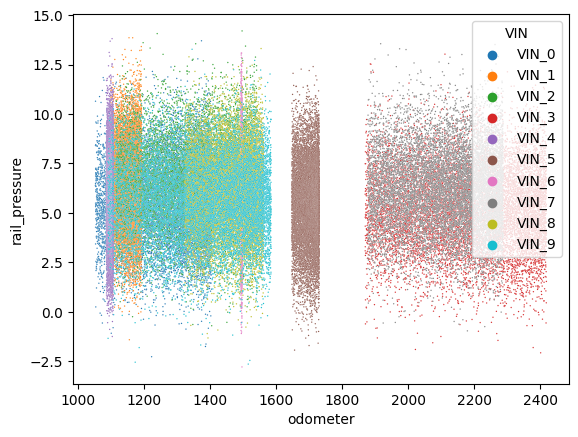

In [13]:
sns.scatterplot(data=pandas_df, x='odometer',y='rail_pressure', hue='VIN',s=1)

plt.show()

In [18]:
import plotly.express as px

fig = px.scatter(pandas_df, x='odometer', y='rail_pressure', color='VIN',
                 title='Scatter Plot: Odometer vs. Rail Pressure', width=800, height=500)
fig.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
fig.show()